![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 1</a>


## Convolutional Neural Networks with Gluon

In this notebook, we strengthen the fundamental understanding of Convolutional Neural Network (CNN) by using built-in CNN architectures in [Gluon](https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/index.html) to train a multiclass classification model on a real-world dataset.

1. <a href="#1">A Toy Example</a>
    * <a href="#11">Convolution 2D</a> 
    * <a href="#12">Padding and Stride</a>
    * <a href="#13">Computing the Shape</a>
    * <a href="#14">Pooling</a>
    
    
2. <a href="#2">A Real-world Example - MINC</a>
    * <a href="#21">Loading the datasets</a>
    * <a href="#22">Designing the Network Architectures</a>

In [1]:
! pip install -q -r ../requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p39/bin/python3.9 -m pip install --upgrade pip' command.


Notice that, if you are running on GPU, please ensure you are:
1. using library `mxnet-cu101` >= 1.6.0, and
1. using library `d2l` >= 0.14.0

by running the following updating command. You can see more details for the D2L installation in this [page](https://d2l.ai/chapter_installation/index.html).

In [2]:
! pip list | egrep mxnet

mxnet-cu112                   1.9.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p39/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
! pip list | egrep d2l

d2l                           0.17.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p39/bin/python3.9 -m pip install --upgrade pip' command.


After the sanity check, let's import the packages for this notebook:

In [4]:
import os
from d2l import mxnet as d2l
import numpy as np
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score

## 1. <a name="1">A Toy Example</a>
(<a href="#0">Go to top</a>)

### 1.1 <a name="11">Convolution 2D</a>
(<a href="#0">Go to top</a>)

Firstly, let's use the built-in CNN classes in Gluon with a toy example. Gluon has a variety of convolutional layers 
such as 


```pythong
nn.Conv1D()
nn.Conv2D()
nn.Conv3D()
```

and more operators [here](https://beta.mxnet.io/api/gluon/nn.html#convolutional-layers). 


### 1.2 <a name="12">Padding and Stride</a>
(<a href="#0">Go to top</a>)

In the built-in classes, we can also add padding and stride. Recall that:

"padding" adds rows/columns around the input, 

![Padding.](https://d2l.ai/_images/conv-pad.svg)


while "stride" refers to the number of “unit” the kernel shifted per slide over rows/columns.

![Stride.](https://d2l.ai/_images/conv-stride.svg)



### 1.3 <a name="13">Computing the Shape</a>
(<a href="#0">Go to top</a>)


Let's experiment an example with input shape of (3, 3), with a kernel size of 2, padding size of 1 on both sides and stride size of (2, 3). The output shape of the `Conv2D()` should be:

\begin{align}
\text{ Output shape} & = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor \\
 & = \lfloor(3 - 2 + 2*1 + 2) / 2\rfloor \times \lfloor(3 - 2 + 2*1 + 3) / 3\rfloor \\
 & = (2, 2)
\end{align}

Let's validate in code! To check the output of the convolution layers, we define the `comp_conv2d` function as forward propogation.

In [5]:
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # Add batch and channel dimension.
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions
    return Y.reshape(Y.shape[2:])

Now we can verify the output shape of the Conv2D layer.

In [6]:
X = nd.random.uniform(shape=(3, 3))
conv2d = nn.Conv2D(channels=1, kernel_size=2, padding=1, strides=(2,3))
comp_conv2d(conv2d, X).shape

(2, 2)

### 1.4 <a name="14">Pooling</a>
(<a href="#0">Go to top</a>)

Recall max pooling returns the maximal value in the pooling window, while average pooling summizes the means.

![Pooling.](https://d2l.ai/_images/pooling.svg)

We can also import built-in pooling layer from Gluon with Padding and Stride, such as `MaxPool2D()` or `AvgPool1D()`. See full list of built-in pooling architectures [here](https://beta.mxnet.io/api/gluon/nn.html#pooling-layers).

In [7]:
X = nd.arange(16).reshape((1, 1, 4, 4))
print(X)
pool2d = nn.MaxPool2D(pool_size=3, padding=1, strides=2)
pool2d(X)


[[[[ 0.  1.  2.  3.]
   [ 4.  5.  6.  7.]
   [ 8.  9. 10. 11.]
   [12. 13. 14. 15.]]]]
<NDArray 1x1x4x4 @cpu(0)>



[[[[ 5.  7.]
   [13. 15.]]]]
<NDArray 1x1x2x2 @cpu(0)>

## 2. <a name="2">A Real-world Example - MINC</a>
(<a href="#0">Go to top</a>)

[MINC](http://opensurfaces.cs.cornell.edu/publications/minc/) is short for Materials in Context Database, provided by Cornell. __We will use a subset of this dataset with the following classes: brick, carpet, food, mirror, sky, water.__ It is well labeled and has a moderate size thus is perfect to be our example.


![MINC 2500 Examples.](https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/datasets/MINC-2500.png)


### 2.1 <a name="21">Loading the datasets</a>
(<a href="#0">Go to top</a>)

First, let's  define the paths for train, validation and test dataset. 

In [8]:
path = '../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

It is a good practice to visualize what does the dataset look like! Let's define the `show_images` function and see some sample images in MINC.

In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

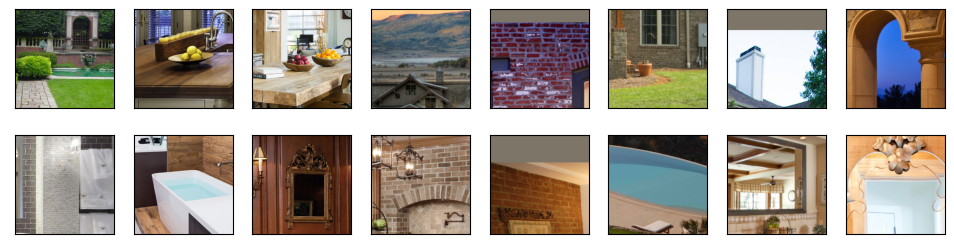

In [10]:
test_sample = gluon.data.DataLoader(gluon.data.vision.ImageFolderDataset(test_path),
                                    batch_size=2*8, shuffle=True)

for data, label in test_sample:
    show_images(data, 2, 8);
    break

To load the dataset properly, we need the massage the image data a bit by some `transfom` functions. First, we load the image data and resize it to the given size (224,224). Next, we convert the image NDArray of shape (H x W x C) in the range [0, 255] to a float32 tensor NDArray of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize an tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [11]:
transformation = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of Gluon, which reads a minibatch of data with size `batch_size` each time.

In [12]:
batch_size = 16

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transformation),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transformation),
    batch_size=batch_size, shuffle=False)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transformation),
    batch_size=batch_size, shuffle=False)

### 2.2 <a name="22">Designing the Network Architectures</a>
(<a href="#0">Go to top</a>)

Now it's the time to design the CNN neural networks! First, let's initailize a `Sequential` block. In Gluon, `Sequential` defines a container for several layers that will be chained together. Given input data, a `Sequential` passes it through the first layer, in turn passing the output as the second layer’s input and so forth.

We will build a neural netword with a 2D convolutional layer `Conv2D`, following by a 2D maxpooling layer `MaxPool2D`, a fully connected (or `Dense`) layer, and a final output `Dense` layer with output classes 23.

In [13]:
out_classes = 6

net = gluon.nn.Sequential()
net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))

# The Flatten layer collapses all axis, except the first one, into one axis.
net.add(gluon.nn.Flatten())
net.add(gluon.nn.Dense(128, activation='relu'))
net.add(gluon.nn.Dense(out_classes))

Our network is almost ready to be trained! One last thing before the training is to set up the hyperparameters, such training context `ctx` (GPU or CPU), the number of epochs to train, the learning rate of optimization algorithms. Besides, we specify the loss function. Since this problem is a multiclass classification task, we will use softmax as our loss funciton.

In [14]:
ctx = d2l.try_gpu() # Set this to CPU or GPU depending on your training instance

epochs = 10
learning_rate = 0.01
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

We can intialize the weights randomly by calling `initialize` in the predefined context `ctx`. 

To infer the neural network "how to optimize its weights", we instantiate the `Trainer`, which defines the parameters to optimize over (obtainable from our net via net.collect_params()), the optimization algorithm we wish to use (sgd), and a dictionary of hyperparameters required by our optimization algorithm. SGD just requires that we set the value learning_rate.

In [15]:
net.collect_params().initialize(init.Xavier(magnitude=2.24), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

[19:37:28] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8400 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset).

In [16]:
for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_etropy_loss(output, label)
        loss.backward()
        train_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += (output.argmax(axis=1) == label.astype('float32')).mean()
        val_loss += softmax_cross_etropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))

[19:37:49] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Epoch 0: train loss 1.713, train acc 0.292, val loss 1.561, val acc 0.339
Epoch 1: train loss 1.504, train acc 0.410, val loss 1.431, val acc 0.438
Epoch 2: train loss 1.340, train acc 0.497, val loss 1.277, val acc 0.474
Epoch 3: train loss 1.207, train acc 0.543, val loss 1.165, val acc 0.531
Epoch 4: train loss 1.048, train acc 0.604, val loss 1.234, val acc 0.531
Epoch 5: train loss 0.906, train acc 0.681, val loss 1.085, val acc 0.604
Epoch 6: train loss 0.771, train acc 0.735, val loss 1.135, val acc 0.583
Epoch 7: train loss 0.631, train acc 0.783, val loss 1.059, val acc 0.615
Epoch 8: train loss 0.560, train acc 0.828, val loss 1.129, val acc 0.594
Epoch 9: train loss 0.451, train acc 0.858, val loss 1.002, val acc 0.635


As you may notice that the training loss and accurcay keep improving, while the validation loss and accuracy are fluctuated. This is a signal of overfitting. As a result, in the following sessions, we will show you more advanced neural network architectures (such as AlexNet and ResNet) to stablize the training!